<a href="https://colab.research.google.com/github/Yamito548/Trabajos-cursos-IA-y-big-data/blob/main/Clasificaci%C3%B3n_de_im%C3%A1genes_(Carlos_act).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

El dataset que vamos a utilizar esta sacado desde [kaggle](https://www.kaggle.com/datasets/niteshfre/chessman-image-dataset?resource=download). Básicamente lo que haremos será un ejercicio de clasificación usando redes reurnonales para la clasificación de piezas de ajedrez. También usé de  [ayuda](https://www.kaggle.com/code/hariharanalm/95-accuracy-tensorflow-chess)

# Cargamos los datos

Cargamos varias de las librerías que vamos a usar en este trabajo.

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import *
from tensorflow.keras import layers
%matplotlib inline

Tuve un pequeño problema a la hora de hacer esta parte, ya que me metía por defecto el archivo en root y no tenía los permisos para poder resolver ese problema pero usando **chatgpt** pues pude modificar la línea de carga de los datos para que poder indicarle dónde quería que estuviese exactamente, siendo en mi caso en /content. A pesar de lo anterior no paraba de darme problemas por lo que decidí usar la función de drive para que me funcione correctamente ya que por alguna razón no me leía bien ninguno de los formato de compresión que existen. Haciendo esto, si me dejaba descomprimir el archivo en cuestión.

# EMPEZAMOS

In [ ]:
#Cargamos los datos de entrenamiento.
from google.colab import drive
#Montamos mi unidad de drive.
drive.mount('/content/drive')
#Descomprimimos el archivo zip
!unzip /content/drive/MyDrive/rar/ajedrez.zip -d /content

En esta parte, vemos cuantas fotos y sus formatos hay. Por simple curiosidad y ver si había mucha diferencia en temas de cantidad siendo que sí, ya que hay muchas más fotos con formato **jpg** que con **png**.

# OTRO METODO DE PRUEBA

In [3]:
#Almacenamos la ruta para guardar las imágenes.
ruta = []

#Recorremos las carpetas que tienen las imágenes
for dirname, _, filenames in os.walk("/content/Chessman-image-dataset"):
  for filename in filenames:
    ruta.append(os.path.join(dirname,filename))

#Creamos el dataset
ruta = pd.DataFrame(ruta, columns=["Imagen"])

En esta parte, lo que hago es una mejora del anterior código. Añado una lista y un bucle, en el bucle guardo, el nombre del directorio principal, los nombres de las subcarpetas (las etiquetas) y por último el nombre de las imágenes. Ya en la otra parte del bucle, recorremos el subdirectorio actual y añadimos los nombres de las imágenes. Además con la parte del os.path.jpin lo que haremos será juntar la ruta del archivo junto a su nombre.

Ahora junto al dataset de imágenes, vamos a añadir sus categorías.

In [4]:
clases_dataset = []

for paths in ruta['Imagen']:
  m=paths.split('/')
  if len(m) <=8:
    for i in range(len(m)):
      if m[i] == 'Chessman-image-dataset':
        clases_dataset.append(m[i+1])
clases_dataset= pd.DataFrame(clases_dataset, columns=['Categoría'])

Aquí tuve un error importante, ya que esta parte **"if m[i] == 'Chessman-image-dataset':"** puse un nombre que no era, y por lo tanto a la hora de crear el dataframe, me daba bien en el sentiedo de que me lo creaba pero en la categoría me salía todo el rato NaN, por lo que al menos sabía que no era problema de un código erroneo en sí sino que había alguna variable mal escrita.

In [5]:
#Vemos el dataset con las imágenes.
data=pd.concat([ruta,clases_dataset],axis=1)
data

,Imagen,Categoría
0,/content/Chessman-image-dataset/Knight/0000008...,Knight
1,/content/Chessman-image-dataset/Knight/0000014...,Knight
2,/content/Chessman-image-dataset/Knight/0000009...,Knight
3,/content/Chessman-image-dataset/Knight/0000017...,Knight
4,/content/Chessman-image-dataset/Knight/0000004...,Knight
...,...,...
551,/content/Chessman-image-dataset/King/00000003.jpg,King
552,/content/Chessman-image-dataset/King/00000056.jpg,King
553,/content/Chessman-image-dataset/King/00000069.jpg,King
554,/content/Chessman-image-dataset/King/00000194.jpg,King


In [6]:
import os

# Directorio raíz que deseas recorrer
directorio_raiz = '/content/Chessman-image-dataset'

# Inicializar un contador para el total de archivos
total_archivos = 0

# Recorrer el directorio raíz y sus subdirectorios
for directorios, _, name_files in os.walk(directorio_raiz):
  num_archivos = len(name_files)

  print(f"La cantidad de archivos de {directorios} es de {num_archivos}")

  total_archivos+=num_archivos

print(f"La cantidad total de archivos en todos los directorios es de {total_archivos}")

La cantidad de archivos de /content/Chessman-image-dataset es de 0
La cantidad de archivos de /content/Chessman-image-dataset/Knight es de 106
La cantidad de archivos de /content/Chessman-image-dataset/Pawn es de 107
La cantidad de archivos de /content/Chessman-image-dataset/Queen es de 78
La cantidad de archivos de /content/Chessman-image-dataset/Bishop es de 87
La cantidad de archivos de /content/Chessman-image-dataset/Rook es de 102
La cantidad de archivos de /content/Chessman-image-dataset/King es de 76
La cantidad total de archivos en todos los directorios es de 556


Tenía duda de cuantos archivos había por cada subcarpeta, y como pensaba, el bucle se para en la subcarpeta **Pawn**. Por lo que el total de archivos es mayor que 556, pero al no recorrer esas carpetas no cuenta. Quice hacer una prueba, para comprobar si había algún problema más por lo que no recorría el bucle por lo que en este mismo código indiqué que me contará solo las dos últimas subcarpetas, dandome que en la de **Queen** había 78 archivo y en la de **Rook** 102.Dando un total real de 736 archivos. Puede que la diferencia entre las cantidades de las imágenes lleve a un rendimiento algo bajo.

In [7]:
categorias_diferentes = data['Categoría'].unique()
categorias_diferentes

array(['Knight', 'Pawn', 'Queen', 'Bishop', 'Rook', 'King'], dtype=object)

Aunque buscando las categorías dentro de mi dataset, veo que estan todas las categorías y más adelante podremos ver que si que hay imágenes de las categorías las cuales supuestamente no habían entrado. Eso sí, no estoy seguro de que se hayan almacenado todas las que posee pero apriori todo va bien.

# Vemos imágenes almacenadas del dataset

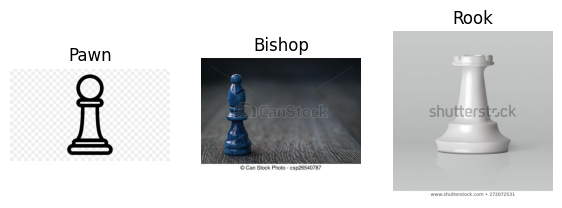

In [8]:
#Guardamos 3 imágenes
img1=cv2.imread(data['Imagen'][200])
img2=cv2.imread(data['Imagen'][300])
img3=cv2.imread(data['Imagen'][400])

#Para la primera figura
plt.figure(figsize=(7,7))
plt.subplot(2,3,1)
plt.imshow(img1)
plt.title(data['Categoría'][200])
plt.axis('off')

#Para la segunda figura
plt.subplot(2,3,2)
plt.imshow(img2)
plt.title(data['Categoría'][300])
plt.axis('off')

#Para la tercera figura
plt.subplot(2,3,3)
plt.imshow(img3)
plt.title(data['Categoría'][400])
plt.axis('off')
plt.show()

Esto es simplemenete para ver algunos ejemplos de nuestro dataset, con el mismo tamaño.

In [9]:
#Ahora vamos a procesar las imágenes para su uso en python
from PIL import Image
X = []
for path in data["Imagen"]:
  Imagen = Image.open(path)
  nueva_imagen = np.array(Imagen)
  X.append(nueva_imagen)

Ya esto comienza a tener más familiridad para mi, debido a que ya estamos dividiendo los datos en X y Y, siendo X los datos y Y la categoría que queremos etiquetar, como las actividades de dataset que hemos hecho en clases de Salvador. Las convertimos en numpy simplmente para que tengan un formato más sencillo de procesar.

In [10]:
print(f"Vemos la cantidad de valores que tiene la {len(X)}")

Vemos la cantidad de valores que tiene la 556


In [11]:
# Lista auxiliar para almacenar las imágenes redimensionadas con dimensiones correctas
X_redimensionado = []
# Redimensionar las imágenes y eliminar aquellas con dimensiones incorrectas
for i in range(len(X)):
    imagen_redimensionada = cv2.resize(X[i], (256, 256))
    forma_redimensionada = imagen_redimensionada.shape
    # Verificar si la forma de la imagen redimensionada es diferente a (256, 256, 3)
    if forma_redimensionada == (256, 256, 3):
        X_redimensionado.append(imagen_redimensionada)

# Convertir la lista de imágenes redimensionadas con dimensiones correctas a una matriz NumPy
X = np.stack(X_redimensionado)
len(X)

555

Ahora vamos a redimencionar las imágenes, para que tengan un tamaño más pequeño y que sean más faciles de procesar, así como que el proceso no dure demasiado. Tuve otro problema, en este caso de que una imágen de las 556 que tenía no se redimensionaba correctamente, intenté otros metodos pero este fue el que sirvió, que es simplemente almacenar todas las imágenes que si que rendimensionaron bien, es decir la gran mayoría. Y no meter la única que daba problemas.

In [12]:
#Obtenemos nuestra y de categorías
y = data['Categoría']
y = y[:-1]
len(y)

555

He quitado el útlimo registro debido a que al haber quitado el registro que daba fallos en la X, la cual daba problemas a la hora de redinmensionar las imágenes. Sino hacia esto pues a la hora de dividir los datos me daría problemas debido a que en la X habría una fila menos que la y pero con este ajuste solucioné el problema.

In [14]:
#Normalizamos los datos, para que tengan valores entre 0 y 1.
X= X/255

Esto es necesario para que los procesos sean más rápidos y sencillos. Al dividirlos por 255 hará que todos los números esten por debajo de 1 haciendo así que al ser procesados sea más sencillo.

In [15]:
#Ahora codificamos las categorías, es decir las pasamos a números.
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y)
label = encoder.fit_transform(data["Categoría"].unique())
code = dict(zip(label,data["Categoría"].unique()))
code

{2: 'Knight', 3: 'Pawn', 4: 'Queen', 0: 'Bishop', 5: 'Rook', 1: 'King'}

Aquí ya hemos convertido las características a un valor númerico usando laberencoder, esto es para que el sistema lo pueda leer correctamente sino dará problemas a la hora de procesarlo ya que solo puede procesar números.

# Modelos

In [16]:
#Usaremos el modelo sequential
model = Sequential()

#Añadimos más información a nuestra capa.
model.add(Conv2D(filters=8,kernel_size=(4,4),strides=(1,1),input_shape=(256,256,3),kernel_initializer='random_normal',activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
#Añadimos una segunda capa
model.add(Conv2D(filters=16, kernel_size=(4,4),strides=(1,1),kernel_initializer='random_normal',activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
#Añadimos una tercera capa
model.add(Conv2D(filters=64,kernel_size=(2,2),strides=(1,1),kernel_initializer='random_normal',activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
#Añadimos una cuarta capa
model.add(Conv2D(filters=128,kernel_size=(2,2),strides=(1,1),kernel_initializer='random_normal',activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Flatten())
from tensorflow.keras import regularizers
#Probar para ver si mejora kernel_regularizer=regularizers.l2(0.01)
model.add(Dense(activation='relu', units=32,kernel_regularizer=regularizers.l2(0.1)))
#Añadimos un dropout para evitar o reducir el overfitting
model.add(Dropout(0.20))
model.add(Dense(activation='relu', units=16,kernel_regularizer=regularizers.l2(0.1)))
model.add(Dropout(0.20))
#Última capa, 6 neuronas por las 6 clases existentes
model.add(Dense(activation='softmax', units=6))

Aquí creamos las capas que habrán en nuestro modelo, con diferentes tamaños y neuronas

In [ ]:
#Vemos la información del modelo
model.summary()

Esto es muy útil para poder ver un resumen de todo lo establecido con anterioridad.

División de los datos

In [18]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(X,y, test_size=0.20, random_state=100, shuffle=True)

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
#Entrenamos el modelo usar entre 200 a 300 epochas. Precisión del 0.85 %
model.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size=32,shuffle=True, epochs = 100)

Epoch 1/100
14/14 [==============================] - 30s 2s/step - loss: 2.9941 - accuracy: 0.1802 - val_loss: 3.0535 - val_accuracy: 0.2162
Epoch 2/100
14/14 [==============================] - 28s 2s/step - loss: 3.0326 - accuracy: 0.1937 - val_loss: 2.8512 - val_accuracy: 0.2072
Epoch 3/100
14/14 [==============================] - 28s 2s/step - loss: 2.6526 - accuracy: 0.2230 - val_loss: 2.4694 - val_accuracy: 0.2252
Epoch 4/100
14/14 [==============================] - 28s 2s/step - loss: 2.3892 - accuracy: 0.2162 - val_loss: 2.2810 - val_accuracy: 0.2072
Epoch 5/100
14/14 [==============================] - 28s 2s/step - loss: 2.2062 - accuracy: 0.2050 - val_loss: 2.1634 - val_accuracy: 0.1892
Epoch 6/100
14/14 [==============================] - 28s 2s/step - loss: 2.1101 - accuracy: 0.2387 - val_loss: 2.0890 - val_accuracy: 0.1622
Epoch 7/100
14/14 [==============================] - 27s 2s/step - loss: 2.0545 - accuracy: 0.2230 - val_loss: 2.0885 - val_accuracy: 0.1892
Epoch 8/100
1

Entrenamos el modelo con unas 70 epocas. Lo deje en esta cantidad debido a que a más épocas peor iba el modelo a nivel de accuracy. Luego fui toqueteando los pesos del modelo hasta ajustarlo y que me quedase de esa manera, es decir con un validation accuracy de **0.53 %**. Que sigue siendo bajo pero es mucho mejor rendimiento que el que me daba sin usar las técnicas de regularización.

In [ ]:
grafico = model.history
plt.plot(grafico.history['accuracy'],label="Precisión con datos de entrenamiento")
plt.plot(grafico.history['val_accuracy'],label="Precisión con datos de validación")
plt.legend()

Vemos un gráfico en donde se comparan los datos de entrenamiento frente a los de validación y podemos así ver sus diferencias y si esta siendo el entramiento efectivo o no. En est caso no mucho la verdad, ya que la gráfica del train es más alta que la de validación.

In [ ]:
# Evaluamos el modelo con los datos de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print("Precisión final en los datos de prueba:", accuracy)

# Realizamos una predicción
predictions = model.predict(X_test)

# Mostramos algunas predicciones junto con las etiquetas reales
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[i])
    plt.title("Predicción: {}\nEtiqueta Real: {}".format(code[np.argmax(predictions[i])], code[y_test[i]]))
    plt.axis('off')
plt.show()


# SEGUIMOS SIN PARTE DE PRUEBA

In [ ]:
#Vemos la cantidad de imágenes que tienen formato jpg y png en todos los directorios del dataset.
import pathlib
data_dir = '/content/Chessman-image-dataset'
data_dir = pathlib.Path(data_dir).with_suffix('')

#Buscamos los tipos de imágenes
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count2 = len(list(data_dir.glob('*/*.png')))

print(f"""
      El número de imágenes con formato jpg es de {image_count} con formato png hay {image_count2}.
      Y hay unas 10 con JPG, pero en mayúsculas.""")

# Visualización de los datos

En esta parte vemos los datos, para ver como son.

In [ ]:
import PIL #Librería para manipular y abrir fotos en python
queen = list(data_dir.glob('Queen/*')) #Seleccionamos la carpeta con las fotos que queremos ver
PIL.Image.open(str(queen[0])) #Seleccionamos la foto que veremos

In [ ]:
#Vemos el tamaño de la imagen
PIL.Image.open(str(queen[0])).size

# Dividimos los datos

In [ ]:
#Definimos el tamaño de las imágenes, el tamaño del batch y las épocas que usaremos
img_height,img_width,batch_size = 300,300,64
epochs = 50
#Train
print("División para los datos de train")
train = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset='training',
    seed = 100,
    image_size= (img_height,img_width),
    batch_size=batch_size
)
#Validación
print("\nDivisión para los datos de validation")
validacion = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed = 100,
    image_size= (img_height,img_width),
    batch_size=batch_size
)

Ya hemos dividio los datos en train y validación. Todos los datos se han codigo de las subcarpetas del dataset y tienen el mismos tamaño que fue especificado en image_size

# Estandarizar los datos

Ahora vamos a estandarizar los datos para que los valores esten entre 0 y 1, para que de mejores resultados a la hora de entrenar.

In [ ]:
capa_estandar = layers.Rescaling(1./255)

Aquí lo que haremos será normalizar a cada conjunto de datos que tiene el conjunto de datos de entrenamiento que hemos creado (entrada y su etiqueta). Lo que hace este código es coger la imagen x y hace una tuple con su etiqueta y.

In [ ]:
#X representa a la imagen y Y a su etiqueta.
estandar_ds = train.map(lambda x, y : (capa_estandar(x), y))
image_batch, labels_batch = (next(iter(estandar_ds)))
first_image = image_batch[2]
print(f"Píxels mínimos: {round((np.min(first_image)),3)} \nPíxels máximos: {round((np.max(first_image)),3)}")

Podemos ver que los píxeles mínimos y máximos no se salen de la escala entre 0 y 1. Como lo establecimos antes.

In [ ]:
from tensorflow import keras
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Básicamente, en la capa de **RandomFlip** (aleatorio horizontal)lo que hacemos es crear nuevas instancias de imágenes a partir de las ya existentes pero las cambiamos de posición, en **RandomRotation** lo que hace es rotar la imágen en un ángulo de 0.1 radientes. Y la última capa, es la de **RandomZoom** la cual hace que se haga zoom a las imágenes de forma aleatoria también con un ángulo de 0.1.

# Modelo aprendizaje profundo

In [ ]:
num_clases = len(train.class_names)
print(f"La cantidad de clases existentes son de {num_clases}.")

Vemos que la cantidad de clases es la correcta, esto se puede comprobar facilmente al ir a la carpeta del dataset y contar las subcarpetas que este posee, siendo efectivamente 6.

In [ ]:
model = Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(16,3, padding="same",activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(num_clases)
])

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
entrenamiento =model.fit(train, validation_data=validacion, epochs=epochs)